In [1]:
import AutoEngagement as AE
import pandas as pd
ae = AE.AutoEngagement()  # A class



Video_address="D:\Datasets\engagement\engage\clips_masked"
Frame_address="D:/Datasets/engagement/engage/Frames"
Label_address="D:/Datasets/engagement/engage/videolabels_Maria_1stweek.csv"
New_Label_address="D:/Datasets/engagement/engage/videolabels_Maria_1stweek_new.csv"
Train_ds="D:/Datasets/engagement/engage/Train_ds.csv"

# Data Process

In [12]:

videos = ae.Load_Video(Video_address)  # A class

Info=videos.info()  # A dict, All meta information
Info["Video_List"] # Store Video absolution address
print(Info["metaInfo"]) # Includes total length, resolution, Video Count.

#videos.to_Frame(Frame_address)  # Convert Video into frame files.
#videos.Calculate_Minimal_Box(Frame_address) # It should search each sub dir, for each dir, it should have 0.jpg, then for 0.jpg, there are many 0 value, you should detect the minimal bound(Rectangle) of aviable pixel, then store the bounding box into json named as Bounding Box
#videos.Clip(Frame_address) # Clip all jpg according to json bounding,
 

{'Video Number': 51, 'Total Time': 3172.480000000001, 'Resolution': [(1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720), (1280, 720)]}


In [ ]:

frames=ae.Load_Image(Frame_address)   # Return Dataframe: Video_Num, Frame,  Adress
print(frames.head())

labels=ae.Load_Label(Label_address) #Return Dataframe: Video_Num, Start, End,  Label  
#labels.to_csv(New_Label_address)

labels

In [11]:
frames

,Video_Num,Frame,Address
0,00001_0,0,D:/Datasets/engagement/engage/Frames\00001_0\0...
1,00001_0,1000,D:/Datasets/engagement/engage/Frames\00001_0\1...
2,00001_0,10000,D:/Datasets/engagement/engage/Frames\00001_0\1...
3,00001_0,10040,D:/Datasets/engagement/engage/Frames\00001_0\1...
4,00001_0,10080,D:/Datasets/engagement/engage/Frames\00001_0\1...
...,...,...,...
79256,00039_0,9800,D:/Datasets/engagement/engage/Frames\00039_0\9...
79257,00039_0,9840,D:/Datasets/engagement/engage/Frames\00039_0\9...
79258,00039_0,9880,D:/Datasets/engagement/engage/Frames\00039_0\9...
79259,00039_0,9920,D:/Datasets/engagement/engage/Frames\00039_0\9...


In [4]:
#image_labels=ae.Merge_Label(frames, labels) #Return Dataframe: Video_Num, Start, End,  Label  
#image_labels.to_csv(Train_ds)
df=pd.read_csv(Train_ds)
filter_list = ['00001_0', '00004_0', '00002_0']
df = df[df['Video_Num'].isin(filter_list)]


In [14]:
df

,Unnamed: 0,Video_Num,Frame,Address,Label
0,0,00001_0,0,D:/Datasets/engagement/engage/Frames\00001_0\0...,527.0
1,1,00001_0,1000,D:/Datasets/engagement/engage/Frames\00001_0\1...,649.0
2,2,00001_0,10000,D:/Datasets/engagement/engage/Frames\00001_0\1...,797.0
3,3,00001_0,10040,D:/Datasets/engagement/engage/Frames\00001_0\1...,797.0
4,4,00001_0,10080,D:/Datasets/engagement/engage/Frames\00001_0\1...,798.0
...,...,...,...,...,...
6166,6166,00004_0,9800,D:/Datasets/engagement/engage/Frames\00004_0\9...,640.0
6167,6167,00004_0,9840,D:/Datasets/engagement/engage/Frames\00004_0\9...,640.0
6168,6168,00004_0,9880,D:/Datasets/engagement/engage/Frames\00004_0\9...,640.0
6169,6169,00004_0,9920,D:/Datasets/engagement/engage/Frames\00004_0\9...,640.0


<Axes: ylabel='Frequency'>

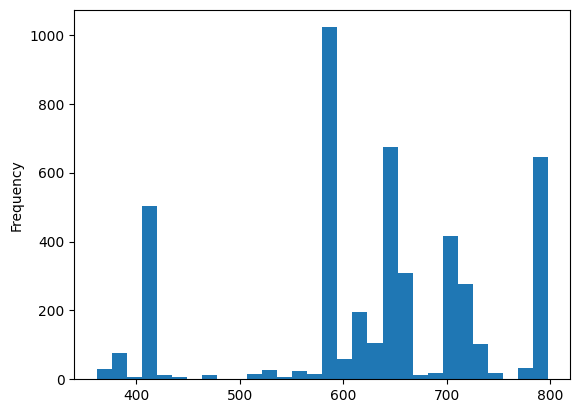

In [5]:
df["Label"].plot(kind='hist', bins=30)

# Training

In [6]:
num_workers=2
batch_sizes=128

import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.imgs = list(dataframe['Address'])
        self.labels = list(dataframe['Label'])
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = Image.open(self.imgs[idx]).convert("RGB")  # Convert image to RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    

    
from pytorch_lightning import LightningDataModule
from torch.utils.data import random_split, DataLoader

class CustomImageDataModule(LightningDataModule):
    def __init__(self, dataframe, transform=None, batch_size=64):
        super().__init__()
        self.dataframe = dataframe
        self.transform = transform
        self.batch_size = batch_size

    def prepare_data(self):
        self.dataset = CustomImageDataset(self.dataframe, self.transform)

    def setup(self, stage=None):
        train_len = int(len(self.dataset)*0.8)
        val_len = len(self.dataset) - train_len

        self.train_dataset, self.val_dataset = random_split(self.dataset, [train_len, val_len])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)
 

C:\Users\isxzl\anaconda3\envs\Engagement\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import torch
from torchvision import models, transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer

class ImageRegression(pl.LightningModule):
    def __init__(self):
        super(ImageRegression, self).__init__()
        
        # Load the pre-trained ResNet18 model
        self.model = models.resnet18(pretrained=True)
        
        # Replace the last fully connected layer to return only one output (for regression)
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, 1)
        
        self.criterion = torch.nn.MSELoss()
        self.criterion2 = torch.nn.L1Loss()
    def forward(self, x):
        output = self.model(x)
        output = torch.squeeze(output, 1)  # remove the additional dimension
        return output
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.float()
        y = y.float()
        y_pred = self.forward(x)
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.float()
        y = y.float()
        y_pred = self.forward(x)
        loss = self.criterion2(y_pred, y)
        self.log('val_loss', loss, prog_bar=True)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    
# Define your transformations here
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization for ImageNet
])


# Let's say df is your dataframe containing the image paths and labels
data_module = CustomImageDataModule(df, transform, batch_size=batch_sizes)

model = ImageRegression()  # Defined previously
trainer = pl.Trainer(max_epochs=100, accelerator="gpu",log_every_n_steps=5,check_val_every_n_epoch=1)
torch.set_float32_matmul_precision('medium')
trainer.fit(model, data_module)
 

C:\Users\isxzl\anaconda3\envs\Engagement\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\isxzl\anaconda3\envs\Engagement\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type    | Params
---------------------------------------
0 | model      | ResNet  | 11.2 M
1 | criterion  | MSELoss | 0     
2 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\isxzl\anaconda3\envs\Engagement\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\isxzl\anaconda3\envs\Engagement\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|███████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s, v_num=45]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s, v_num=45, val_loss=607.0]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|███████████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s, v_num=45, val_loss=585.0]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|███████████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s, v_num=45, val_loss=562.0]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|███████████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s, v_num=45, val_loss=526.0]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|███████████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s, v_num=45, val_loss=491.0]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|███████████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s, 

C:\Users\isxzl\anaconda3\envs\Engagement\lib\site-packages\pytorch_lightning\trainer\call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [8]:
trainer.validate(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    10.573346138000488     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 10.573346138000488}]

# Evaluate

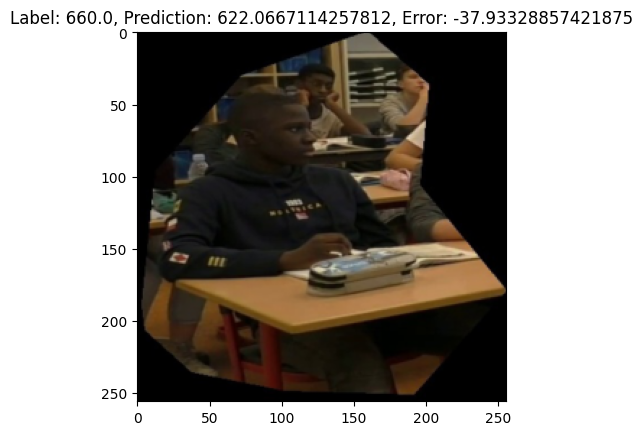

In [10]:
import matplotlib.pyplot as plt

# Assuming you have a trained model and a data_module

# Get a batch of data
data_iter = iter(data_module.val_dataloader())  # or change to train_dataloader, test_dataloader as required
images, labels = next(data_iter)  # this will give a batch of images and labels

# Select the first image in the batch
image = images[0]
label = labels[0]

# Make a prediction with the model
image = image.unsqueeze(0)  # add an extra dimension for batch
pred = model(image)

# Calculate the error
error = ((pred - label)).item()  # this is the squared error

# Denormalize image if it's normalized
image = image.squeeze(0)  # remove the extra batch dimension
image_denormalized = image * torch.Tensor([0.229, 0.224, 0.225])[:, None, None] + torch.Tensor([0.485, 0.456, 0.406])[:, None, None]  # assuming ImageNet normalization
image_denormalized = image_denormalized.permute(1, 2, 0)  # change from C,H,W to H,W,C for plotting

# Plot the image
plt.imshow(image_denormalized)
plt.title(f'Label: {label.item()}, Prediction: {pred.item()}, Error: {error}')
plt.show()


In [41]:
tensorboard --logdir benchmark_logs/ 

^C


In [ ]:
sqrt((797-276)^)